In [43]:
import tensorflow as tf
import tarfile
import os
import pandas as pd
import numpy as np
import re
from tabulate import tabulate
from collections import Counter
from itertools import combinations
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from tabulate import tabulate
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix

## Data Preprocessing

#### Extract the tar file and grab it's contents. Also ensure that the extraction file exists.

In [2]:

tar_path = 'pu_corpora_public.tar'
extract_to = 'pu_corpora_public'

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

with tarfile.open(tar_path) as tar:
    tar.extractall(path=extract_to)

extracted_contents = os.listdir(extract_to)
extracted_contents

['pu_corpora_public', '.DS_Store']

#### List the files of the dataset, including readme file and list them

In [3]:

subdirectory_path = os.path.join(extract_to, 'pu_corpora_public')
subdirectory_contents = os.listdir(subdirectory_path)
subdirectory_contents

['.DS_Store', 'pu1', 'pua', 'readme.txt', 'pu2', 'pu3']

#### Examine the readme file

In [4]:

readme_path = os.path.join(subdirectory_path, 'readme.txt')

with open(readme_path, 'r') as file:
    readme_contents = file.read()

print(readme_contents[:500])

This directory contains the PU1, PU2, PU3, and PUA corpora, as 
described in the paper:

I. Androutsopoulos, G. Paliouras, E. Michelakis, "Learning to 
Filter Unsolicited Commercial E-Mail", submitted for journal 
publication, 2003.

There are 4 directories (pu1, pu2, pu3, pua), each containing
one of the four corpora. 

Each one of the 4 directories in turn contains 11 subdirectories 
(part1, ..., part10, unused). These correspond to the 10 partitions 
of each corpus that were used in the 10-fo


#### Let's see what the data formatting looks like in one of the subdirectories

In [5]:

sample_corpus_path = os.path.join(subdirectory_path, 'pu1', 'part1')


sample_corpus_contents = os.listdir(sample_corpus_path)
sample_corpus_contents[:10]

['1988legit13.txt',
 '1221legit54.txt',
 '1198legit14.txt',
 '1394spmsg90.txt',
 '1110legit57.txt',
 '1545legit49.txt',
 '177spmsg68.txt',
 '1716legit2.txt',
 '1926spmsg88.txt',
 '1489legit32.txt']

Notice that emails that are not spap are considered "legit"

#### Let's take a look at one of the text files

In [6]:

def is_spam(filename):
    return 'spmsg' in filename

def load_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        return file.read()
sample_file_path = os.path.join(sample_corpus_path, sample_corpus_contents[0])
sample_file_content = load_text_file(sample_file_path)
print(sample_file_content[:500])

Subject: 5573 47

3677 22660 15981 9594 5573 2130 16502 22064 15981 9594 84 19054 9594 16893 7913 1613 16502 8615 3617 1991 3677 22660 80 4695 19054 12995 8890 84 16502 9594 7602 6217 1967 16502 17157 1991 16502 15779 20385 15981 9594 80 14911 897 16993 19283 18957 3617 80 14338 180 631 1967 180 2521 14766 15820 4978 22328 84 19054 15981 9594 1847 17912 2130 1594 180 18316 20215 23479 14338 7088 6485 1835 3677 22660 84 19889 1967 19410 18065 1594 23772 2130 51 22064 132 1672 84 7423 84 14000 51 


Notice that the emails have already been tokenized - the dataset has already been preprocessed to some extent

## EDA

Before we begin modeling, let's explore the data. The code below loops through each file in the "pu_corpora_public" folder and reads it into a single dataframe.

In [7]:
# Root drive for text files
root_dir = "pu_corpora_public/pu_corpora_public"

# Initialize empty lists to store emails
email_texts = []
labels = []

# Iterate through each folder (pu1, pu2, pu3, pua)
for folder in ['pu1', 'pu2', 'pu3', 'pua']:
    folder_path = os.path.join(root_dir, folder)

    # Iterate through each "part" folder
    for part in range(1, 11):
        part_folder_path = os.path.join(folder_path, 'part' + str(part))

        # Iterate through each file
        for file_name in os.listdir(part_folder_path):
            file_path = os.path.join(part_folder_path, file_name)

            # Check if file is a text file and contains 'spmsg' or 'legit' in the file name
            if file_name.endswith('.txt'):
                with open(file_path, 'r', encoding='latin-1') as file:
                    email_text = file.read()

                    email_texts.append(email_text)

                    # Determine if email is spam or ham
                    if 'spmsg' in file_name:
                        labels.append(1)
                    elif 'legit' in file_name:
                        labels.append(0)


df = pd.DataFrame({'text': email_texts, 'spam': labels})
df.head()


,text,spam
0,Subject: 5573 47\n\n3677 22660 15981 9594 5573...,0
1,Subject: 5581 2130 2005 47\n\n1791 13383 80 89...,0
2,Subject: 1368 15860 14338 5915 82 101 3124\n\n...,0
3,Subject: 7265 131 14950 7721 47 47 2176 13757 ...,1
4,Subject: 167 190 82 3115 171 5652 2221 118 186...,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7070 entries, 0 to 7069
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7070 non-null   object
 1   spam    7070 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 110.6+ KB


The dataframe contains 7,070 emails in total. The data has been read into one column named "text" which contains the tokenized contents of the email, and a "spam" column that denotes ham emails as 0 and spam emails as 1.

In [9]:
# Calculate number of spam emails
num_spam_emails = df[df['spam'] == 1]['spam'].count()

# Calculate number of ham emails
num_ham_emails = df[df['spam'] == 0]['spam'].count()

# Calculate the total number of emails
total_emails = len(df)

# Calculate percentages of spam/ham emails
percent_spam = (num_spam_emails / total_emails) * 100
percent_ham = (num_ham_emails / total_emails) * 100

# Create a table with the results
data = [
    ["Spam Emails", "{:,}".format(num_spam_emails), "{:.2f}%".format(percent_spam)],
    ["Ham Emails", "{:,}".format(num_ham_emails), "{:.2f}%".format(percent_ham)]
]

headers = ["Category", "Number of Emails", "Percent"]
print(tabulate(data, headers=headers))

Category     Number of Emails    Percent
-----------  ------------------  ---------
Spam Emails  3,010               42.57%
Ham Emails   4,060               57.43%


The emails are split roughly evenly between ham and spam emails

In [10]:
# Calculate the number of words in each email
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

# Calculate average, min, and max number of words for spam emails
spam_df = df[df['spam'] == 1]
avg_words_spam = spam_df['num_words'].mean()
min_words_spam = spam_df['num_words'].min()
max_words_spam = spam_df['num_words'].max()

# Calculate average, min, and max number of words for ham emails
ham_df = df[df['spam'] == 0]
avg_words_ham = ham_df['num_words'].mean()
min_words_ham = ham_df['num_words'].min()
max_words_ham = ham_df['num_words'].max()

# T-Tests
t_statistic_avg, p_value_avg = stats.ttest_ind(spam_df['num_words'], ham_df['num_words'])
t_statistic_min, p_value_min = stats.ttest_ind(spam_df['num_words'], ham_df['num_words'])
t_statistic_max, p_value_max = stats.ttest_ind(spam_df['num_words'], ham_df['num_words'])

# Determine if there is a statistical difference
stat_diff_avg = "Yes" if p_value_avg < 0.05 else "No"
stat_diff_min = "Yes" if p_value_min < 0.05 else "No"
stat_diff_max = "Yes" if p_value_max < 0.05 else "No"

data = {
    "Category": ["Spam Emails", "Ham Emails"],
    "Average Words": [avg_words_spam, avg_words_ham],
    "Minimum Words": [min_words_spam, min_words_ham],
    "Maximum Words": [max_words_spam, max_words_ham],
    "P-value (Avg)": [p_value_avg, ""],
    "P-value (Min)": [p_value_min, ""],
    "P-value (Max)": [p_value_max, ""],
    "Statistical Difference (Avg)": [stat_diff_avg, ""],
    "Statistical Difference (Min)": [stat_diff_min, ""],
    "Statistical Difference (Max)": [stat_diff_max, ""]
}

df_stats = pd.DataFrame(data)
df_stats


,Category,Average Words,Minimum Words,Maximum Words,P-value (Avg),P-value (Min),P-value (Max),Statistical Difference (Avg),Statistical Difference (Min),Statistical Difference (Max)
0,Spam Emails,758.860797,2,10284,0.01863,0.01863,0.01863,Yes,Yes,Yes
1,Ham Emails,627.662808,4,134885,,,,,,


Using a t-test, we can see that there is a statistically significant differences between the average number of words in spam vs ham emails (759 vs 628, respectively).

In [11]:
ham_words = df[df['spam'] == 0]['text'].apply(lambda x: len(x.split()))
spam_words = df[df['spam'] == 1]['text'].apply(lambda x: len(x.split()))

# Calculate the quartiles and interquartile range for ham and spam emails
ham_q1, ham_q3 = ham_words.quantile([0.25, 0.75])
ham_iqr = ham_q3 - ham_q1

spam_q1, spam_q3 = spam_words.quantile([0.25, 0.75])
spam_iqr = spam_q3 - spam_q1

# Define the thresholds for outliers
ham_outlier_threshold = 1.5 * ham_iqr
spam_outlier_threshold = 1.5 * spam_iqr

# Identify outliers for ham and spam emails
ham_outliers = ham_words[(ham_words < (ham_q1 - ham_outlier_threshold)) |
                         (ham_words > (ham_q3 + ham_outlier_threshold))]

spam_outliers = spam_words[(spam_words < (spam_q1 - spam_outlier_threshold)) |
                           (spam_words > (spam_q3 + spam_outlier_threshold))]

# Count the number of outliers
num_ham_outliers = len(ham_outliers)
num_spam_outliers = len(spam_outliers)

print("Number of outliers in ham emails:", num_ham_outliers)
print("Number of outliers in spam emails:", num_spam_outliers)


Number of outliers in ham emails: 343
Number of outliers in spam emails: 344


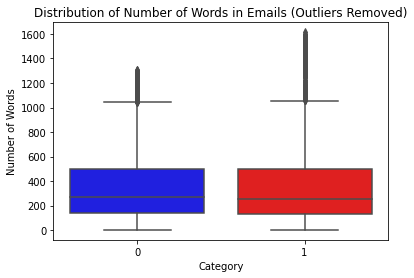

In [12]:
# Remove outliers from ham and spam words
ham_words_no_outliers = ham_words[~ham_words.isin(ham_outliers)]
spam_words_no_outliers = spam_words[~spam_words.isin(spam_outliers)]

# Create a boxplot without outliers
sns.boxplot(data=[ham_words_no_outliers, spam_words_no_outliers], palette=["blue", "red"])

# Set labels and title
plt.xlabel('Category')
plt.ylabel('Number of Words')
plt.title('Distribution of Number of Words in Emails (Outliers Removed)')

# Show the plot
plt.show()


#### Distribution of number of words in both ham and spam emails

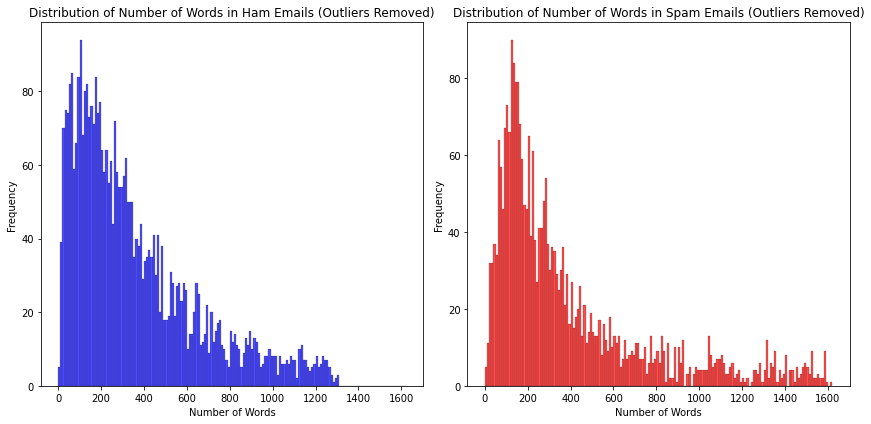

In [13]:

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Remove outliers from ham and spam words
ham_words_no_outliers = ham_words[~ham_words.isin(ham_outliers)]
spam_words_no_outliers = spam_words[~spam_words.isin(spam_outliers)]

# Calculate the maximum number of words among both ham and spam emails
max_words_no_outliers = max(ham_words_no_outliers.max(), spam_words_no_outliers.max())

# Set bins for the histogram
bins = range(0, max_words_no_outliers + 10, 10)

# Plot the distribution of number of words in ham emails
sns.histplot(ham_words_no_outliers, bins=bins, color='blue', alpha=0.7, ax=axes[0])
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Number of Words in Ham Emails (Outliers Removed)')

# Plot the distribution of number of words in spam emails
sns.histplot(spam_words_no_outliers, bins=bins, color='red', alpha=0.7, ax=axes[1])
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Number of Words in Spam Emails (Outliers Removed)')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


#### Calc number of unique words for both spam and ham emails

In [14]:
# Concatenate all ham emails into a single string
ham_emails_text = ' '.join(df[df['spam'] == 0]['text'])

# Concatenate all spam emails into a single string
spam_emails_text = ' '.join(df[df['spam'] == 1]['text'])

# Split the concatenated strings into words
ham_words = ham_emails_text.split()
spam_words = spam_emails_text.split()

# Count the number of unique words
num_unique_ham_words = len(set(ham_words))
num_unique_spam_words = len(set(spam_words))

print("Number of unique words in ham emails:", num_unique_ham_words)
print("Number of unique words in spam emails:", num_unique_spam_words)


Number of unique words in ham emails: 52686
Number of unique words in spam emails: 42384


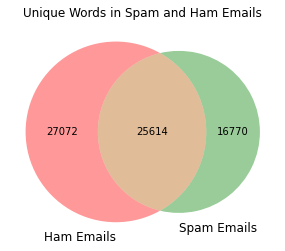

In [15]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate the number of unique words in ham and spam emails
unique_ham_words = set(ham_words)
unique_spam_words = set(spam_words)
intersection_words = unique_ham_words.intersection(unique_spam_words)

# Calculate the unique words exclusive to ham and spam emails
unique_ham_exclusive = unique_ham_words - intersection_words
unique_spam_exclusive = unique_spam_words - intersection_words

# Create the Venn diagram
venn2(subsets=(len(unique_ham_exclusive), len(unique_spam_exclusive), len(intersection_words)),
      set_labels=('Ham Emails', 'Spam Emails'))

# Set title
plt.title('Unique Words in Spam and Ham Emails')

# Show the plot
plt.show()


## Modeling

Now we'll move on to the modeling phase. We'll build an initial model, and build from there to get the most accurate model we can find. Let's start with a fresh/clean dataset.

In [16]:

def load_data_from_directory(directory_path, sample_size_per_category=100):
    files = os.listdir(directory_path)
    contents = []
    labels = []

    spam_count = 0
    legit_count = 0

    for file in files:
        if spam_count >= sample_size_per_category and legit_count >= sample_size_per_category:
            break

        file_path = os.path.join(directory_path, file)
        content = load_text_file(file_path)

        content = re.sub(r'Subject:.*\n?', '', content, count=1)

        if is_spam(file) and spam_count < sample_size_per_category:
            contents.append(content)
            labels.append(1)
            spam_count += 1
        elif not is_spam(file) and legit_count < sample_size_per_category:
            contents.append(content)
            labels.append(0)
            legit_count += 1

    return pd.DataFrame({'content': contents, 'label': labels})

In [17]:
# Loading a balanced sample dataset
sample_data = load_data_from_directory(sample_corpus_path)
sample_data.head()

,content,label
0,\n3677 22660 15981 9594 5573 2130 16502 22064 ...,0
1,\n1791 13383 80 8962 2130 15184 17345 9131 217...,0
2,\n1835 23758 17345 16531 16502 7634 17753 2040...,0
3,\n22180 11245 14338 2649 13406 1124 47 47 47 4...,1
4,\n82 82 82 82 82 82 82 82 82 82 82 82 82 82 82...,0


In [18]:
sample_data.shape

(109, 2)

#### Splitting the dataframe into training and validation sets. Then convert into numpy arrays for tensorflow

In [19]:

X_train, X_val, y_train, y_val = train_test_split(sample_data['content'], sample_data['label'], test_size=0.2, random_state=42)


X_train = np.array([np.fromstring(x, sep=' ') for x in X_train])
X_val = np.array([np.fromstring(x, sep=' ') for x in X_val])

X_train.shape, X_val.shape

/var/folders/sq/sf7z67k14rz104b31mjqffpm0000gn/T/ipykernel_52849/3184755257.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array([np.fromstring(x, sep=' ') for x in X_train])
/var/folders/sq/sf7z67k14rz104b31mjqffpm0000gn/T/ipykernel_52849/3184755257.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_val = np.array([np.fromstring(x, sep=' ') for x in X_val])


((87,), (22,))

#### Get the sequence lengths and find reasonable padding length

In [20]:
'''
Getting the sequence lengths then figuring out a reasonable padding length
I'm printing out the basic stats to help figure it out.

'''

sequence_lengths = [len(np.fromstring(x, sep=' ')) for x in sample_data['content']]

sequence_length_stats = {
    'mean': np.mean(sequence_lengths),
    'median': np.median(sequence_lengths),
    'max': np.max(sequence_lengths),
    'min': np.min(sequence_lengths),
    'std': np.std(sequence_lengths)
}

sequence_length_stats

{'mean': 920.183486238532,
 'median': 453.0,
 'max': 12862,
 'min': 10,
 'std': 1596.6688153096563}

#### Set the sequence lengths to 500, just slightly above the median

In [21]:

sequence_length = 500

X_train_padded = pad_sequences(X_train, maxlen=sequence_length, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val, maxlen=sequence_length, padding='post', truncating='post')

X_train_padded.shape, X_val_padded.shape

((87, 500), (22, 500))

#### Here are the model parameters. We're adjusting this based on the dataset's vocabulary and the size of the vectors

In [22]:
'''
Here are the model parameters
I am adjusting this based on the
dataset's vocabulary and
the size of the vectors.

'''

vocab_size = 20000
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_shape=(sequence_length,)),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,089 (5.01 MB)

 Trainable params: 1,313,089 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model on padded data

In [23]:

history = model.fit(X_train_padded, y_train, epochs=10, validation_data=(X_val_padded, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.4273 - loss: 0.6940 - val_accuracy: 0.5909 - val_loss: 0.6902
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6690 - loss: 0.6894 - val_accuracy: 0.6364 - val_loss: 0.6882
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6637 - loss: 0.6829 - val_accuracy: 0.6364 - val_loss: 0.6837
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6150 - loss: 0.6755 - val_accuracy: 0.6364 - val_loss: 0.6781
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5916 - loss: 0.6675 - val_accuracy: 0.6364 - val_loss: 0.6707
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6637 - loss: 0.6376 - val_accuracy: 0.6364 - val_loss: 0.6579
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.7003 - loss: 0.6034 - val_accuracy: 0.6364 - val_loss: 0.6530
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7139 - loss: 0.5384 - val_accuracy: 0.4545 - val_loss:

#### Evaluating the model

In [24]:
loss, accuracy = model.evaluate(X_val_padded, y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4545 - loss: 0.6643
Validation Accuracy: 45.45%


The model above just a sample of the data. There really isn't enough data to build a reasonable model by just using a sample. So, now we will use the entire dataset.

#### This is a function written in order to load all of the data within the dataset instead of just a sample.

In [25]:
'''
This is a function written in order to
load all of the data within my dataset
instead of just a sample
'''

def load_all_data(directory_path):
    all_contents = []
    all_labels = []

    for corpus_dir in ['pu1', 'pu2', 'pu3', 'pua']:
        corpus_path = os.path.join(directory_path, corpus_dir)

        for part in os.listdir(corpus_path):
            part_path = os.path.join(corpus_path, part)

            if not os.path.isdir(part_path):
                continue

            for file in os.listdir(part_path):
                file_path = os.path.join(part_path, file)
                content = load_text_file(file_path)

                content = re.sub(r'Subject:.*\n?', '', content, count=1)

                all_contents.append(content)
                all_labels.append(1 if 'spmsg' in file else 0)


    return pd.DataFrame({'content': all_contents, 'label': all_labels})


entire_dataset = load_all_data(subdirectory_path)
entire_dataset.head(), entire_dataset.shape

(                                             content  label
 0  \n284 6818 80 284 13383 80 127 93 84 489 18798...      0
 1  \n16502 21946 7634 16893 15149 1613 16538 80 1...      0
 2  \n14338 7488 2221 20439 103 80 12116 18469 187...      0
 3  \n4822 80 16502 2410 1967 180 262 1847 12146 1...      1
 4  \n478 17188 130 20259 12808 80 196 17054 1812 ...      1,
 (7101, 2))

In [26]:

# Building the numpy arrays for the entire dataset

X = np.array([np.fromstring(text, sep=' ') for text in entire_dataset['content']])
y = entire_dataset['label'].values

/var/folders/sq/sf7z67k14rz104b31mjqffpm0000gn/T/ipykernel_52849/2497282042.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array([np.fromstring(text, sep=' ') for text in entire_dataset['content']])


In [27]:
sequence_lengths = [len(np.fromstring(x, sep=' ')) for x in entire_dataset['content']]

sequence_length_stats = {
    'mean': np.mean(sequence_lengths),
    'median': np.median(sequence_lengths),
    'max': np.max(sequence_lengths),
    'min': np.min(sequence_lengths),
    'std': np.std(sequence_lengths)
}

sequence_length_stats

{'mean': 673.6744120546402,
 'median': 290.0,
 'max': 134874,
 'min': 1,
 'std': 2313.5984150545423}

#### Using padding the ensure uniform length. Using 300, since that is slightly above the median

In [28]:

sequence_length = 300
X_padded = pad_sequences(X, maxlen=sequence_length, padding='post', truncating='post')

#### Build the test and train sets

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

#### Building the model

In [30]:

model = Sequential([
    Embedding(input_dim=20000, output_dim=64, input_shape=(sequence_length,)),  # Adjust 'input_dim' as necessary
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.6152 - loss: 0.6399 - val_accuracy: 0.8163 - val_loss: 0.4497
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.8214 - loss: 0.4468 - val_accuracy: 0.8529 - val_loss: 0.4116
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8555 - loss: 0.3811 - val_accuracy: 0.8649 - val_loss: 0.3669
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.8883 - loss: 0.3084 - val_accuracy: 0.8635 - val_loss: 0.4593
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.7421 - loss: 0.5676 - val_accuracy: 0.7241 - val_loss: 0.5174
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.7584 - loss: 0.4466 - val_accuracy: 0.7101 - val_loss: 0.5317
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7655 - loss: 0.4079 - val_accuracy: 0.7185 - val_loss: 0.4979
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.7623 - loss: 0.3806 - val_accurac

In [31]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8817 - loss: 0.3609
Validation Accuracy: 86.98%


### Interpretation and next steps

MThe model is showing initial strong performance. We can see this by the high accuracy and low loss on the validation set.

Something we need to be careful about is potential overfitting. The model might perform better on the training data than on the validation data. We can add some techniques like dropout layers to detect this.

We'll try some optimization techniques now. The lowest hanging fruit here is Early Stopping.

#### Implementing early stopping

In [32]:

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=[early_stopping_callback])

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9341 - loss: 0.2056 - val_accuracy: 0.9205 - val_loss: 0.2427
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9599 - loss: 0.1198 - val_accuracy: 0.9226 - val_loss: 0.2133
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.9752 - loss: 0.0822 - val_accuracy: 0.9254 - val_loss: 0.2188
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.9822 - loss: 0.0628 - val_accuracy: 0.9451 - val_loss: 0.1943
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9894 - loss: 0.0394 - val_accuracy: 0.9416 - val_loss: 0.1866
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9936 - loss: 0.0266 - val_accuracy: 0.9458 - val_loss: 0.1810
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9964 - loss: 0.0197 - val_accuracy: 0.9430 - val_loss: 0.2243
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9960 - loss: 0.0234 - 

Really interesting here. We have a low amount of Epochs (10) but we are not even hitting ten iterations of the model. There is a low patience parameter (3) but I think adjusting Epoch/Patience is not the best move here. We are going to implement something a little different. Let's try a regularization method to solve the problem of overfitting that we are finding here.

#### Model without dropout

In [33]:

vocab_size = 20000
embedding_dim = 64
sequence_length = 300
dropout_rate = 0.5

model = Sequential([
    Input(shape=(sequence_length,)),
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64, return_sequences=False),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 300, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,089 (5.01 MB)

 Trainable params: 1,313,089 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

#### Dropout Model with Early Stopping

In [34]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - accuracy: 0.6044 - loss: 0.6645 - val_accuracy: 0.6524 - val_loss: 0.5840
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.6759 - loss: 0.5783 - val_accuracy: 0.7643 - val_loss: 0.5492
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.7445 - loss: 0.5285 - val_accuracy: 0.7248 - val_loss: 0.5177
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.7333 - loss: 0.4880 - val_accuracy: 0.6925 - val_loss: 0.5515
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 80ms/step - accuracy: 0.7478 - loss: 0.4576 - val_accuracy: 0.7375 - val_loss: 0.4685
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.7749 - loss: 0.3871 - val_accuracy: 0.7586 - val_loss: 0.4471
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.7620 - loss: 0.3967 - val_accuracy: 0.7565 - val_loss: 0.4522
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.7962 - loss: 0.3767 - 

#### Let's try adjusting the learning rate using step decay. This approach will reduce the learning rate by a factor every few epochs

In [40]:

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [41]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9476 - loss: 0.1862 - val_accuracy: 0.9226 - val_loss: 0.2342
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9523 - loss: 0.1512 - val_accuracy: 0.9367 - val_loss: 0.2121
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9573 - loss: 0.1409 - val_accuracy: 0.9416 - val_loss: 0.2176
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9642 - loss: 0.1295 - val_accuracy: 0.9346 - val_loss: 0.2087
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9687 - loss: 0.1040 - val_accuracy: 0.8403 - val_loss: 0.4343
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9385 - loss: 0.1773 - val_accuracy: 0.9282 - val_loss: 0.2531
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9673 - loss: 0.1115 - val_accuracy: 0.9219 - val_loss: 0.3063


95% accuracy on the training set and then 93% accuracy on the test set. No significant signs of overfitting, and given the quality and quanitity of our data, this is a very reasonable result!

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


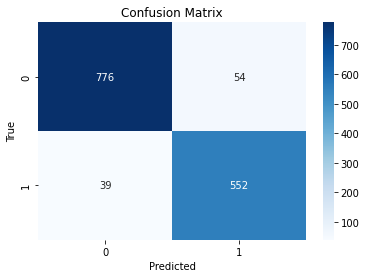

In [44]:
'''

Here is a confusion matrix showcasing False/True Positive/Negatives.
'''

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)


cm = confusion_matrix(y_val, y_pred)


sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

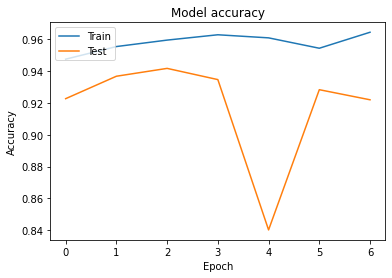

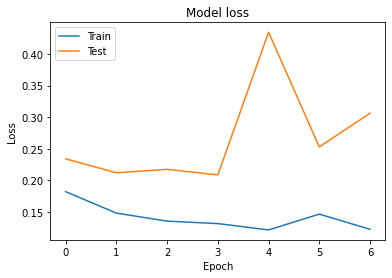

In [45]:
'''
Here are accuracy and loss curves

'''

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()